## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Зеленцов Алексей Викторович

In [51]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import *
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [52]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [53]:
images_train, labels_train = next(iter(train_loader))

In [54]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

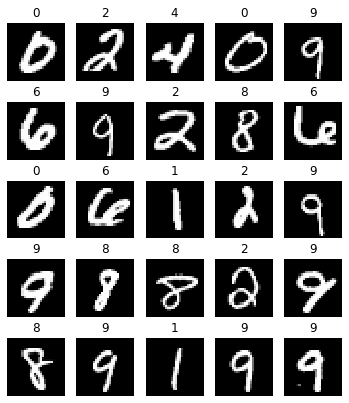

In [55]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [56]:
def init_layer_norm(layer, size, next_size): #unused argument for interface
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0.0, std=0.1)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer_norm(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [57]:
def experiment1(func_init):
    layers = []
    sizes = [28*28] + [500]*10 + [10]
    for size, next_size in zip(sizes, sizes[1:]):
        layer = nn.Linear(size, next_size)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)

        func_init(layer, size, next_size)

        layers.append(layer)
        layers.append(nn.Tanh())

    module = nn.Sequential(*layers)


    X = images_train.reshape(-1, 28*28)
    res = module(X)
    res.mean().backward()

In [58]:
experiment1(init_layer_norm)

forward 0.9874334931373596
forward 0.8483040928840637
forward 0.788298487663269
forward 0.7733268737792969
forward 0.7659705877304077
forward 0.761803150177002
forward 0.7613430023193359
forward 0.7638992071151733
forward 0.7659366130828857
forward 0.7663783431053162
forward 0.7666101455688477
backward 0.0037972263526171446
backward 0.005249094683676958
backward 0.004763924051076174
backward 0.004491677973419428
backward 0.00410489272326231
backward 0.0038972324691712856
backward 0.003768269205465913
backward 0.0038443091325461864
backward 0.0038724709302186966
backward 0.004047510679811239
backward 0.0035077424254268408


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [59]:
def init_layer_xavier(layer, size, next_size):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-np.sqrt(6)/np.sqrt(size + next_size), np.sqrt(6)/np.sqrt(size + next_size))

In [60]:
experiment1(init_layer_xavier)

forward 0.9874334931373596
forward 0.644766092300415
forward 0.49364808201789856
forward 0.41041332483291626
forward 0.36405906081199646
forward 0.3233468532562256
forward 0.2971779406070709
forward 0.27621594071388245
forward 0.2577264606952667
forward 0.24263134598731995
forward 0.23133014142513275
backward 0.003619005437940359
backward 0.017067890614271164
backward 0.01604582369327545
backward 0.015005550347268581
backward 0.014573566615581512
backward 0.012883835472166538
backward 0.01216411404311657
backward 0.010648969560861588
backward 0.008783550933003426
backward 0.006180322729051113
backward 0.003780296305194497


In [61]:
def init_layer_he(layer, size, next_size):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0.0, std=2/size)

In [62]:
experiment1(init_layer_he)

forward 0.9874334931373596
forward 0.07040130347013474
forward 0.006407801527529955
forward 0.000573833764065057
forward 5.226521898293868e-05
forward 4.658782472688472e-06
forward 4.248101106441027e-07
forward 3.822598060310156e-08
forward 3.431375628082378e-09
forward 3.1458921578852994e-10
forward 2.778773391942657e-11
backward 0.0
backward 0.0012811230262741446
backward 0.00011239415471209213
backward 9.646270882512908e-06
backward 8.814296847958758e-07
backward 8.070553292327531e-08
backward 6.876299973868072e-09
backward 5.895408605738339e-10
backward 5.6877745568950644e-11
backward 5.09072298204849e-12
backward 4.463393359337847e-13


<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [63]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        w, b = self.linear.parameters()        

        if self.training:
            mask = torch.zeros_like(w).bernoulli_(self.p)                        
        else:
            mask = torch.ones_like(w) * self.p
        
        mask = mask.data
        mask.requires_grad=False
        output = torch.mm(x, (w*mask).transpose(0, 1)) + b
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

Epoch 4... (Train/Test) NLL: 0.147/0.171	Accuracy: 0.961/0.962


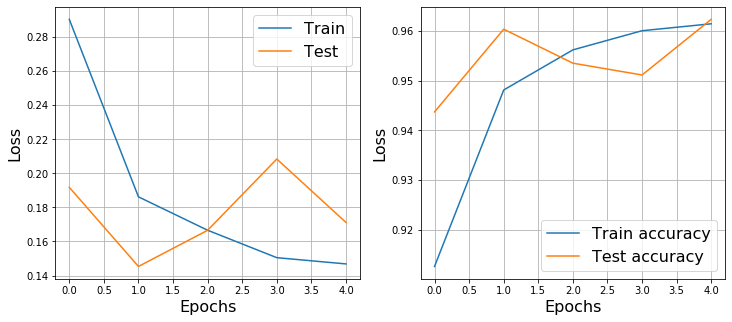

([0.29046380893984586,
  0.18622705745480972,
  0.1666015904924985,
  0.15049261627976956,
  0.14682819881736597],
 [0.19181692260730115,
  0.14534029866792733,
  0.16658068349278427,
  0.2084213553255872,
  0.17117941653049445],
 [0.91269106, 0.9481332, 0.95619005, 0.960038, 0.9614317],
 [0.94373024, 0.96034414, 0.9535206, 0.95114714, 0.962322])

In [69]:
layers = [nn.Flatten()]

sizes = [784, 200, 200, 10]
for size, next_size in zip(sizes, sizes[1:]):
    layers.append(nn.Linear(size, next_size))  
    if next_size != 10:
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.02))
    else:
        layers.append(nn.LogSoftmax())

net = nn.Sequential(*layers)

train(net, train_loader, test_loader, 5, 0.01)

Epoch 4... (Train/Test) NLL: 0.145/0.202	Accuracy: 0.962/0.952


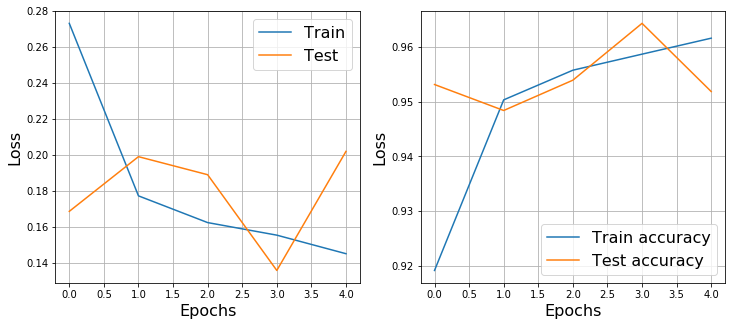

([0.27313845333005826,
  0.17711713879124952,
  0.1622359088854368,
  0.1552400734347067,
  0.1449107514150234],
 [0.16848795111232165,
  0.19893061348437507,
  0.18888859545128256,
  0.13559362235703046,
  0.20187103455956978],
 [0.9191542, 0.95032096, 0.9557403, 0.95867205, 0.9615927],
 [0.953125, 0.94837815, 0.95391613, 0.96429986, 0.9518394])

In [70]:
layers = [nn.Flatten()]

sizes = [784, 200, 200, 10]
for size, next_size in zip(sizes, sizes[1:]):
    if next_size != 10:
        layers.append(DropConnect(size, next_size, 0.95))
        layers.append(nn.ReLU())
    else:
        layers.append(nn.Linear(size, next_size))
        layers.append(nn.LogSoftmax())

net = nn.Sequential(*layers)
train(net, train_loader, test_loader, 5, 0.01)

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [109]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self):
        super(LayerNormalization, self).__init__()
    
    def forward(self, x):
        output = x.sub(x.mean(1, True)).div(x.std(1, True, True))
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 4... (Train/Test) NLL: 0.064/0.141	Accuracy: 0.979/0.973


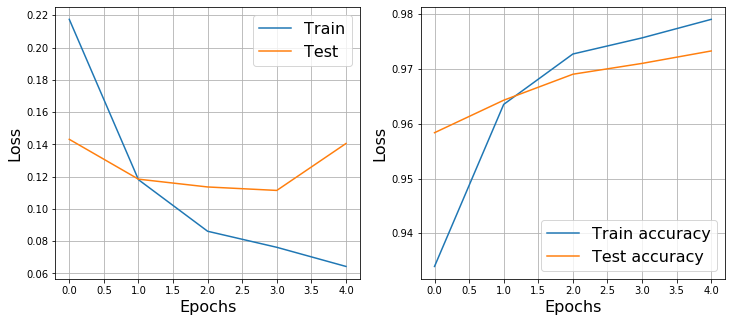

([0.2174660923209653,
  0.11807137566294942,
  0.08609527750993207,
  0.07614238278916491,
  0.06427904752605378],
 [0.1430878652424752,
  0.1183885454990064,
  0.11355291937678298,
  0.11140900972900511,
  0.14050049581741797],
 [0.9339352, 0.9635416, 0.9727423, 0.9756852, 0.9790723],
 [0.9583663, 0.96429986, 0.96904665, 0.9710245, 0.973299])

In [73]:
layers = [nn.Flatten()]

sizes = [784, 200, 200, 10]
#for size, next_size in zip(sizes, sizes[1:]):
    layers.append(nn.Linear(size, next_size))  
    if next_size != 10:
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(num_features=next_size))
    else:
        layers.append(nn.LogSoftmax())

net = nn.Sequential(*layers)

train(net, train_loader, test_loader, 5, 0.01)

Epoch 4... (Train/Test) NLL: 0.056/0.083	Accuracy: 0.982/0.977


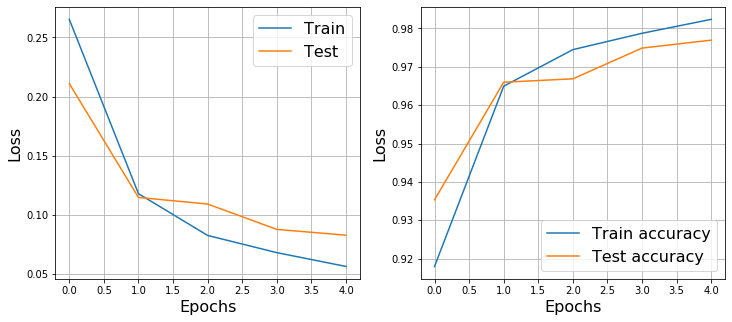

([0.2653333266009527,
  0.11784362723467065,
  0.08249847652779808,
  0.06794511445555716,
  0.05626272169926734],
 [0.21098522210045706,
  0.11464434211389928,
  0.10907075042789212,
  0.0876133191646843,
  0.08270532980596623],
 [0.9179493, 0.96495205, 0.9744803, 0.9787447, 0.98237604],
 [0.9353244, 0.965981, 0.966871, 0.97488135, 0.9769581])

In [110]:
layers = [nn.Flatten()]

sizes = [784, 200, 200, 10]
for size, next_size in zip(sizes, sizes[1:]):
    layers.append(nn.Linear(size, next_size))  
    if next_size != 10:
        layers.append(nn.ReLU())
        layers.append(LayerNormalization())
    else:
        layers.append(nn.LogSoftmax())

net = nn.Sequential(*layers)
train(net, train_loader, test_loader, 5, 0.01)

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: